In [7]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
print("✅ Environment ready!")

✅ Environment ready!


In [8]:
import sys, os
# Force the project root into Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [9]:
from src.config import DB_PATH, TABLEAU_EXPORTS

In [10]:
import os
print(os.getcwd())

/Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/notebooks


,ticker,rows,start,end
0,AAPL,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
1,AMZN,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
2,GOOGL,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
3,HD,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
4,JPM,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
5,KO,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
6,META,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
7,MSFT,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
8,NVDA,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000
9,PEP,2579,2015-12-08 00:00:00.000000,2025-10-24 00:00:00.000000


,ticker,avg_return_pct,avg_volatility_pct
0,NVDA,0.27,38.24
1,TSLA,0.21,41.52
2,AAPL,0.11,21.07
3,MSFT,0.10,15.75
4,META,0.10,22.00
5,GOOGL,0.09,18.42
6,AMZN,0.09,21.62
7,JPM,0.08,17.23
8,V,0.07,13.21
9,UNH,0.07,18.48


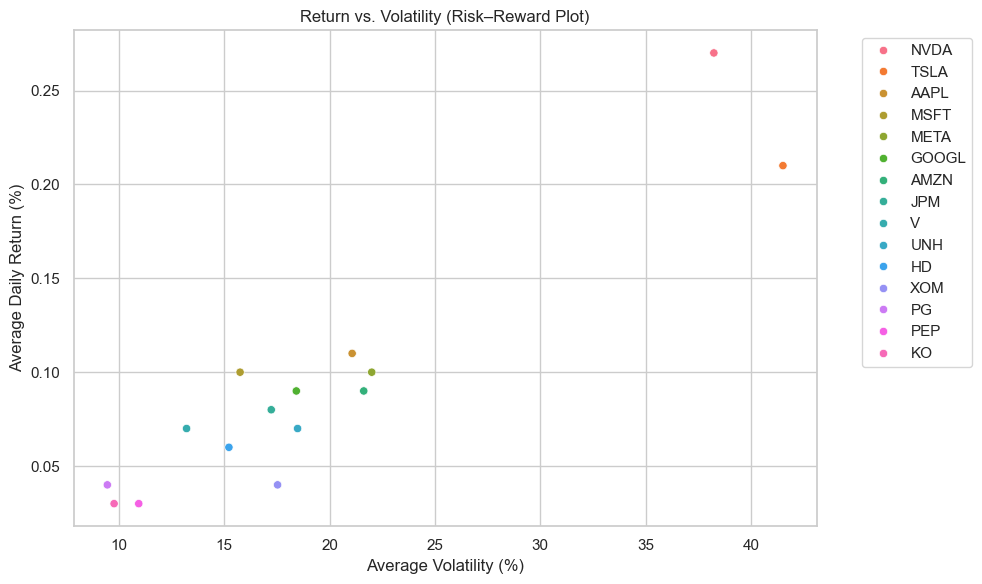

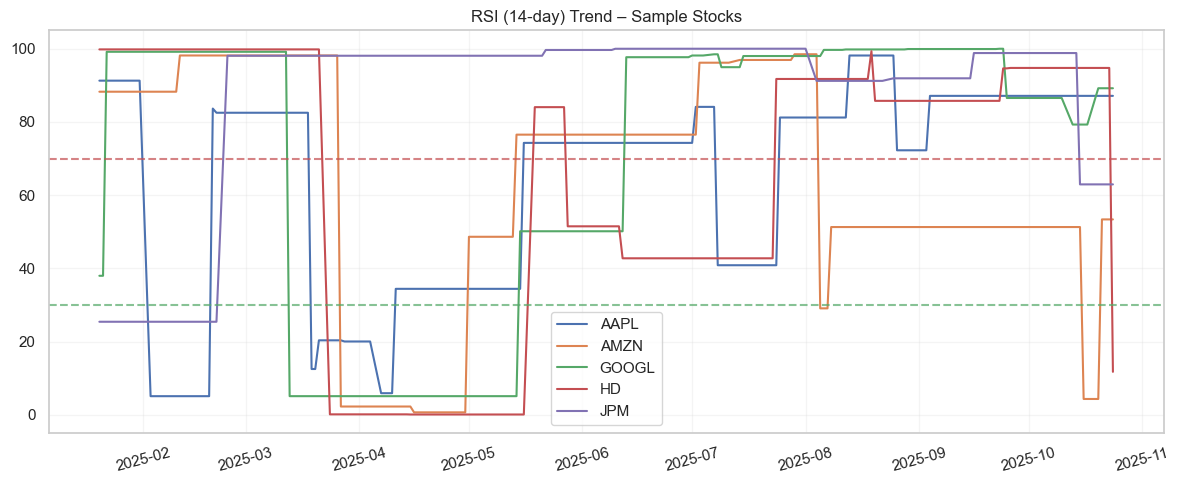

✅ Correlation matrix exported: /Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/tableau/exports/correlation_matrix.csv


ticker,AAPL,AMZN,GOOGL,HD,JPM,KO,META,MSFT,NVDA,PEP,PG,TSLA,UNH,V,XOM
ticker,,,,,,,,,,,,,,,
AAPL,1.00,0.89,0.96,0.97,0.87,0.95,0.82,0.98,0.82,0.90,0.97,0.90,0.89,0.93,0.74
AMZN,0.89,1.00,0.91,0.93,0.87,0.83,0.87,0.91,0.78,0.72,0.89,0.82,0.73,0.93,0.48
GOOGL,0.96,0.91,1.00,0.95,0.93,0.91,0.89,0.97,0.87,0.81,0.92,0.88,0.81,0.93,0.73
HD,0.97,0.93,0.95,1.00,0.89,0.94,0.84,0.97,0.80,0.88,0.96,0.88,0.88,0.96,0.69
JPM,0.87,0.87,0.93,0.89,1.00,0.89,0.95,0.92,0.93,0.66,0.83,0.75,0.66,0.93,0.72


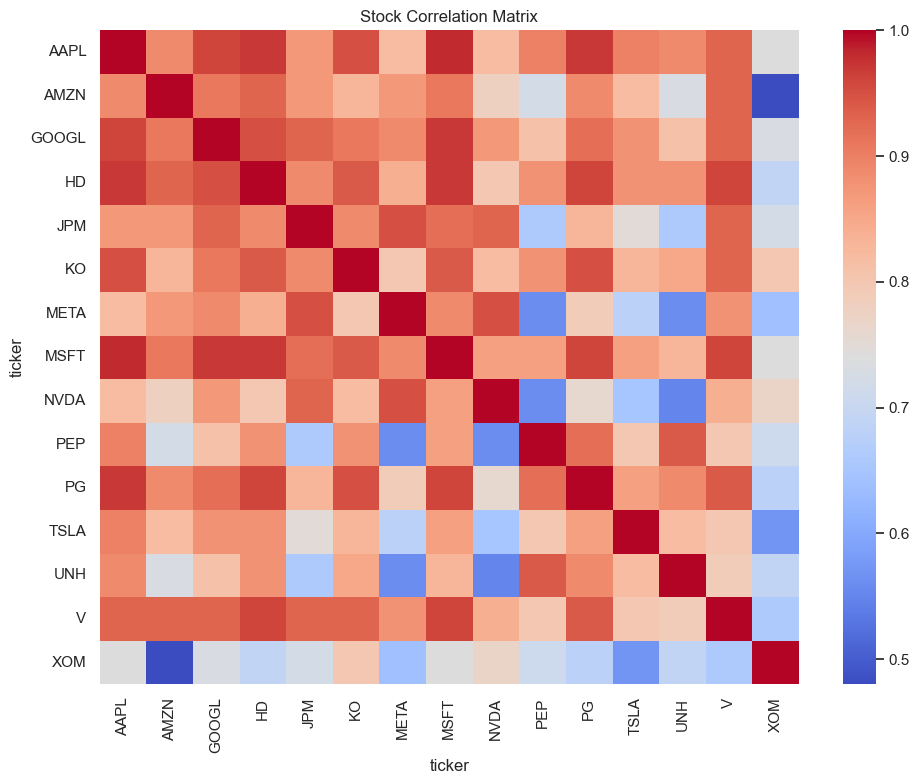

✅ Tableau exports ready in: /Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/tableau/exports
Exists? /Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/tableau/exports/correlation_matrix.csv: True
Exists? /Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/tableau/exports/risk_summary.csv: True
Exists? /Users/darshanpatil/Desktop/Fin Metrics/FinMetrics/tableau/exports/ticker_summary.csv: True


In [11]:
# %% [markdown]
# # FinMetrics – Stage 4: SQL + Exploratory Data Analysis
# Using the cleaned dataset from Stage 3 (SQLite table: `prices_metrics`)

# %%
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src.config import DB_PATH, TABLEAU_EXPORTS

sns.set(style="whitegrid")
Path(TABLEAU_EXPORTS).mkdir(parents=True, exist_ok=True)

# ---- Connect
con = sqlite3.connect(DB_PATH)

# ---- 1) Overview: record count per ticker
summary = pd.read_sql("""
SELECT ticker, COUNT(*) AS rows, MIN(date) AS start, MAX(date) AS end
FROM prices_metrics
GROUP BY ticker
ORDER BY ticker;
""", con)
display(summary)

# ---- 2) Average Daily Returns & Volatility
risk = pd.read_sql("""
SELECT ticker,
ROUND(AVG(daily_return)*100,2) AS avg_return_pct,
ROUND(AVG(volatility_21d)*100,2) AS avg_volatility_pct
FROM prices_metrics
GROUP BY ticker
ORDER BY avg_return_pct DESC;
""", con)
display(risk)

plt.figure(figsize=(10,6))
sns.scatterplot(data=risk, x="avg_volatility_pct", y="avg_return_pct", hue="ticker")
plt.title("Return vs. Volatility (Risk–Reward Plot)")
plt.xlabel("Average Volatility (%)")
plt.ylabel("Average Daily Return (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# ---- 3) RSI & momentum patterns
rsi = pd.read_sql("""
SELECT ticker, date, rsi14
FROM prices_metrics
WHERE rsi14 IS NOT NULL;
""", con)
rsi["date"] = pd.to_datetime(rsi["date"])

plt.figure(figsize=(12,5))
for t in rsi["ticker"].unique()[:5]:
    subset = rsi[rsi["ticker"] == t].tail(200)
    plt.plot(subset["date"], subset["rsi14"], label=t)
plt.axhline(70, color="r", linestyle="--", alpha=0.7)
plt.axhline(30, color="g", linestyle="--", alpha=0.7)
plt.legend()
plt.title("RSI (14-day) Trend – Sample Stocks")
plt.grid(alpha=0.2)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# ---- 4) Correlation matrix for Tableau
df = pd.read_sql("SELECT date, ticker, Close FROM prices_metrics;", con)
df["date"] = pd.to_datetime(df["date"])
pivot = df.pivot(index="date", columns="ticker", values="Close")
corr = pivot.corr().round(2)

corr_path = TABLEAU_EXPORTS / "correlation_matrix.csv"
corr.to_csv(corr_path)
print("✅ Correlation matrix exported:", corr_path)
display(corr.head())

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Stock Correlation Matrix")
plt.tight_layout()
plt.show()

# ---- 5) Save summary CSVs for Tableau
(risk).to_csv(TABLEAU_EXPORTS / "risk_summary.csv", index=False)
(summary).to_csv(TABLEAU_EXPORTS / "ticker_summary.csv", index=False)
print("✅ Tableau exports ready in:", TABLEAU_EXPORTS)

# ---- Close DB + confirm files
con.close()
for f in ["correlation_matrix.csv", "risk_summary.csv", "ticker_summary.csv"]:
    p = TABLEAU_EXPORTS / f
    print(f"Exists? {p}: {os.path.exists(p)}")